In [148]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras import backend as K
import tensorflow as tf
from sklearn import preprocessing
from skimage import exposure
from os import listdir
from scipy import misc
import csv
from math import *
import random
from ipywidgets import widgets
from IPython.display import display
from IPython.html.widgets import *


%matplotlib inline

full_df = pd.DataFrame()

PATH = 'GTSRB/Final_Training/Images'
NORM_W = 32
NORM_H = 32

for label_dir in listdir(PATH):
    try: label_dir.index('000')
    except ValueError: continue
    my_path = '{}/{}/'.format(PATH, label_dir)
    df_csv = pd.read_csv('{}/GT-{}.csv'.format(my_path, label_dir), sep=';')
    df_csv['Path'] = my_path
    full_df = pd.concat([full_df, df_csv])
    

full_label_names = []
with open('signnames.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        full_label_names.append(row[1])

del full_label_names[0]

print ('Label names', full_label_names)
print ('Points in set:', len(full_df))

df, label_names = full_df, full_label_names

Label names ['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)', 'Speed limit (120km/h)', 'No passing', 'No passing for vehicles over 3.5 metric tons', 'Right-of-way at the next intersection', 'Priority road', 'Yield', 'Stop', 'No vehicles', 'Vehicles over 3.5 metric tons prohibited', 'No entry', 'General caution', 'Dangerous curve to the left', 'Dangerous curve to the right', 'Double curve', 'Bumpy road', 'Slippery road', 'Road narrows on the right', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing', 'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing', 'End of all speed and passing limits', 'Turn right ahead', 'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory', 'End of no passing', 'End of no passing by vehicles over 3.5 metric to

/Users/tempflip/.conda/envs/carnd/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[0 1 2 3 4] [ 240 1410 2220 1110  360]


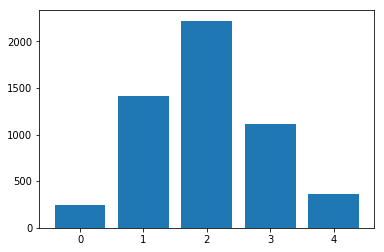

In [149]:
## This for reducing the set -- for test reasons


def reduce_set(n):
    tdf = pd.DataFrame()
    t_label_names = []
    class_id_set = random.sample(range(len(full_label_names)), n)
    for i, class_id in enumerate(class_id_set):
        selected = full_df[full_df['ClassId'] == class_id]
        selected['ClassId'] = i
        tdf = pd.concat((tdf, selected))
        t_label_names.append(full_label_names[class_id])
    return tdf, t_label_names

#@interact(x=widgets.IntSlider(min=2, max=len(full_label_names),step=1,value=5, description="Reduce set to N type of signs"))
def set_size(sender):
    n = int(size_input.value)
    df, label_names = reduce_set(n)
    class_ids, count = np.unique(df['ClassId'].values, return_counts=True)
    print (class_ids, count)
    plt.bar(class_ids, count)
    
size_input = widgets.Text(description="Reduce set to N type of signs", value="5")
button = widgets.Button(description='Set')
button.on_click(set_size)

display(size_input)
display(button)



In [150]:
# training and test sets
# shuffling the samples
df = df.sample(frac=1)

TEST_PROP = 0.2

train_set = df.iloc[0: floor(len(df)*(1-TEST_PROP))]
test_set = df.iloc[floor(len(df) * (1-TEST_PROP)):]

print ('Count of train set: ', len(train_set))
print ('Count of test set: ', len(test_set))


Count of train set:  31367
Count of test set:  7842


In [144]:
# adjust item count in train set
item_count = train_set['ClassId'].value_counts()

adjusted_train_set = pd.DataFrame()

for i, class_id in enumerate(class_id_set):
    selected = train_set[train_set['ClassId'] == i]
    adjusted = selected.sample(n=2000, replace=True)    
    adjusted_train_set = pd.concat((adjusted_train_set, adjusted))
    
train_set = adjusted_train_set
print ('Count of adjusted train set:', len(adjusted_train_set))
    

Count of adjusted train set: 86000


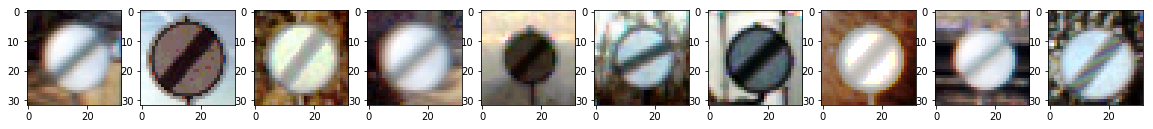

In [151]:
def click_on_button(class_id, norm_hist):
    plt.figure(figsize=(20,5))
    n = 10
    selected = train_set.loc[train_set['ClassId'] == class_id]
    for i in range(n):
        plt.subplot(1, n, i+1)
        img = misc.imresize(misc.imread(selected.iloc[i]['Path'] + selected.iloc[i]['Filename']), (NORM_W, NORM_H))
        if norm_hist:
            img = exposure.equalize_hist(img)
        plt.imshow(img)

interact(click_on_button, 
         class_id={label : class_id for (class_id, label) in enumerate(label_names)},
         norm_hist = False
        )


In [152]:
# the generator
def generator(df, batch_size=100):
    while 1:
        df = df.sample(frac=1)
        X, Y = [], []
        for i in range(batch_size):
            img = misc.imresize(misc.imread(df.iloc[i]['Path'] + df.iloc[i]['Filename']), (NORM_W, NORM_H))
            img = exposure.equalize_hist(img)
            X.append(img)
            Y.append(df.iloc[i]['ClassId'])
        enc = preprocessing.LabelBinarizer()
        enc.fit(range(len(label_names)))

        yield np.float32(X), np.array(enc.transform(Y))
        

In [153]:
n = 2
test_g = generator(train_set, batch_size = n)

X, Y = next(test_g)
print ('Sample Y:', Y[0])
print ('Sample X:', X[0])
print ('Sample X shape:', X[0].shape)


Sample Y: [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
Sample X: [[[ 0.57877606  0.663737    0.78548175]
  [ 0.55045575  0.663737    0.72005206]
  [ 0.7652995   0.78548175  0.86002606]
  ..., 
  [ 0.84016925  0.87076825  0.93164062]
  [ 0.91764325  0.93880206  0.97786456]
  [ 0.92545575  0.95638019  0.99055988]]

 [[ 0.507487    0.60449219  0.7652995 ]
  [ 0.57877606  0.63378906  0.80631512]
  [ 0.69433594  0.663737    0.7652995 ]
  ..., 
  [ 0.8909505   0.93164062  0.98144531]
  [ 0.93880206  0.95638019  0.984375  ]
  [ 0.9534505   0.97786456  0.99316406]]

 [[ 0.69433594  0.7652995   0.84016925]
  [ 0.72005206  0.84016925  0.9534505 ]
  [ 0.48404947  0.63378906  0.81966144]
  ..., 
  [ 0.93880206  0.97786456  0.99446613]
  [ 0.9609375   0.97786456  0.99446613]
  [ 0.97786456  0.98828125  0.99739581]]

 ..., 
 [[ 0.46158853  0.43717447  0.48404947]
  [ 0.33984375  0.41080728  0.41080728]
  [ 0.19401042  0.22298177  0.29524741]
  ..., 
  [ 0.

/Users/tempflip/.conda/envs/carnd/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


In [154]:
model = Sequential()

model.add(Convolution2D(32,3,3, input_shape = (32, 32, 3)))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Activation('relu'))

model.add(Convolution2D(64,3,3))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Activation('relu'))

model.add(Convolution2D(128,3,3,))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(1000))
model.add(Dense(100))
model.add(Dense(len(label_names)))

print (model.output)


Tensor("add_85:0", shape=(?, 43), dtype=float32)


In [155]:
gen = generator(train_set, batch_size=300)
val_gen = generator(train_set, batch_size=300)


model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
history = model.fit_generator(gen, samples_per_epoch=1000, nb_epoch=5, validation_data=val_gen, nb_val_samples=300)



Epoch 1/5


/Users/tempflip/.conda/envs/carnd/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


 900/1000 [==========================>...] - ETA: 0s - loss: 0.1543 - acc: 0.0200

/Users/tempflip/.conda/envs/carnd/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


1200/1000 [====================================] - 9s - loss: 0.1232 - acc: 0.0175 - val_loss: 0.0232 - val_acc: 0.0533
Epoch 2/5
1200/1000 [====================================] - 8s - loss: 0.0249 - acc: 0.0392 - val_loss: 0.0231 - val_acc: 0.0400
Epoch 3/5
1200/1000 [====================================] - 6s - loss: 0.0232 - acc: 0.0425 - val_loss: 0.0228 - val_acc: 0.0533
Epoch 4/5
1200/1000 [====================================] - 7s - loss: 0.0228 - acc: 0.0592 - val_loss: 0.0225 - val_acc: 0.0433

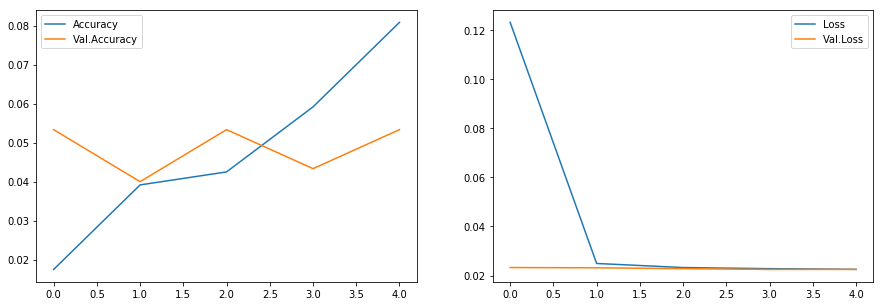

In [156]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['acc'], label='Accuracy')
plt.plot(history.history['val_acc'], label='Val.Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val.Loss')
plt.legend()

In [249]:
# test

TEST_SIZE = 1000
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) # only difference

pr_get = generator(test_set, batch_size=TEST_SIZE)
X, Y = next(pr_get)

pr = model.predict(X)

pred_labels = np.argmax(pr, axis=1)
truth = np.argmax(Y, axis=1)

print (pr[1])

match_ratio = sum(pred_labels == truth)
print ('Matches: {} of {}; {} %'.format( match_ratio, TEST_SIZE, match_ratio / TEST_SIZE * 100) )


/Users/tempflip/.conda/envs/carnd/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


[ -9.33124032e-03  -1.40158394e-02   5.43875918e-02   5.77540100e-02
  -9.99624282e-03   1.92835666e-02   7.51206875e-02   2.42655724e-02
   1.07723400e-02   3.71218696e-02  -7.17541855e-03   2.09356472e-02
   2.49684453e-02   2.88223345e-02  -5.07040182e-03  -3.66675481e-03
   7.34575372e-03   7.23278103e-03  -1.74724404e-03  -6.64694235e-05
  -2.92464159e-03   3.36708315e-02  -6.22336986e-03   1.99420936e-02
   2.88547087e-03   1.61798391e-02   7.84376729e-03  -4.39299038e-04
   1.57355350e-02   6.45292923e-03  -2.23968998e-02   2.03877036e-03
   1.76026523e-02  -1.69679932e-02   5.75572364e-02   6.60662726e-02
   6.02065846e-02   8.35515335e-02   2.72838622e-01  -5.62939886e-03
   5.84080145e-02  -2.06850539e-03   3.26352790e-02]
Matches: 960 of 1000; 96.0 %


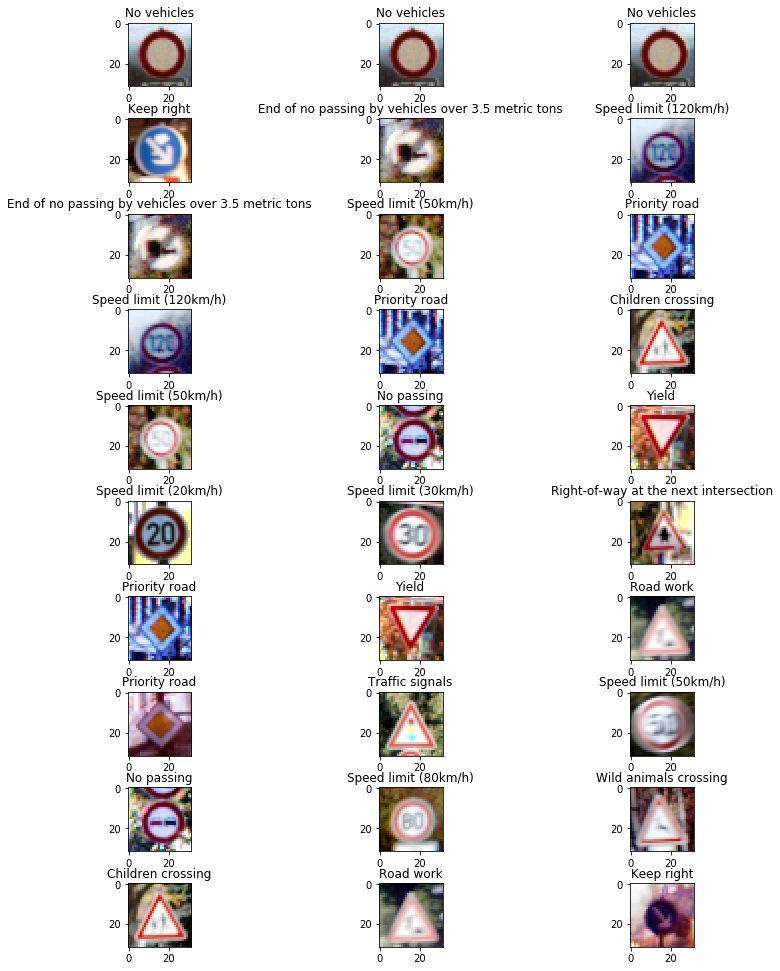

In [250]:
n = 10
m = 3
f, ax = plt.subplots(n,m, figsize = (12,17))
plt.subplots_adjust(hspace = 0.5, wspace=0.5)

for j in range(n):
    for k in range(m):
        i = k * j + j
        
        ax[j,k].imshow(X[i])
        ax[j,k].set_title(label_names[np.argsort(Y[i])[-1]])

